# Solving systems of linear equations

In this chapter we'll see how to recognize problems in which you can apply linear algebra to find the solution to a certain computational question.

Those are known as *systems of linear equations*. These problems are about finding points where lines, planes, or their higher dimensional analogies intersect. One example is the famous math problem about car s leaving two locations at different speeds and finding where they meet.

Those type of problems show up very frequently as in the Asteroids game in which you need to use linear equations to:
+ identify when the laser hits an asteroid &mdash; find whether the line defining the laser beam intersect with the line segments outlining the asteroids. If they do, the asteroid should be destroyed.
+ identify if an asteroid hits the spaceship &mdash; find whether any of the asteroids' segments intersect with the segments defining the spaceship.


## Designing an arcade game

We'll start with a simplified version of the asteroids game where the ship and asteroids are static.

### Modeling the game

In this section we display the spaceship and the asteroids as polygons in the game. We model these as collections of vectors.

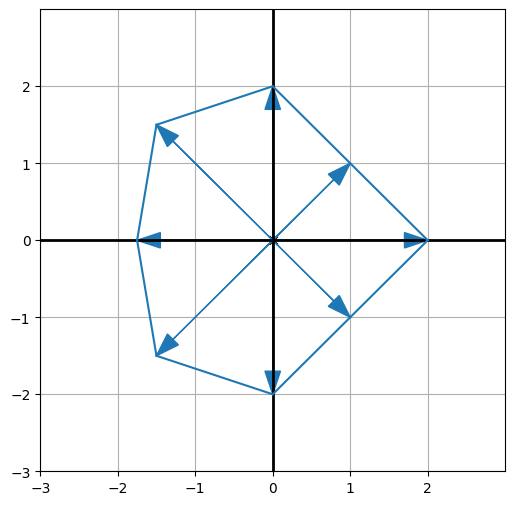

In [6]:
from vec2d.graph import Arrow, Segment, Colors, draw

asteroid_points = [(2, 0), (1, 1), (0, 2), (-1.5, 1.5), (-1.75, 0), (-1.5, -1.5), (0, -2), (1, -1)]

draw(
    *[Arrow(tip, color=Colors.BLUE) for tip in asteroid_points],
    *[Segment(asteroid_points[i], asteroid_points[(i + 1) % len(asteroid_points)]) for i in range(len(asteroid_points))]
)

The asteroid and spaceship will move (*translate*) and rotate as it travels through space, but its shape will remain the same. Thus, to represent these shapes in the game we'll need:
+ the defining vectors/points of the shape
+ its current (x, y) position
+ its current rotation angle

Therefore:

```python
class PolygonModel:
  def __init__(self, points):
    self.points = points
    self.rotation_angle = 0
    self.x = 0
    self.y = 0
```

| NOTE: |
| :---- |
| The source code for the basis of the game is found in [Asteroids: base](../../02_mini-projects/13-asteroids_base/). |

Thus when a shape (either an asteroid or the spaceship) moves we will apply the translation to change the `self.x` and `self.y`, and the rotation to `self.rotation_angle`.

We can subclass `PolygonModel` to represent the spaceship with a `Ship(PolygonModel)` class:

```python
class Ship(PolygonModel):
    def __init__(self) -> None:
        super().__init__([(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)])
```

We can do something similar for the asteroid. We can initialize it with a random number of sides between 5 and 9. We use a simple way involving polar coordinates to make the polygon defining the asteroid to be closed:

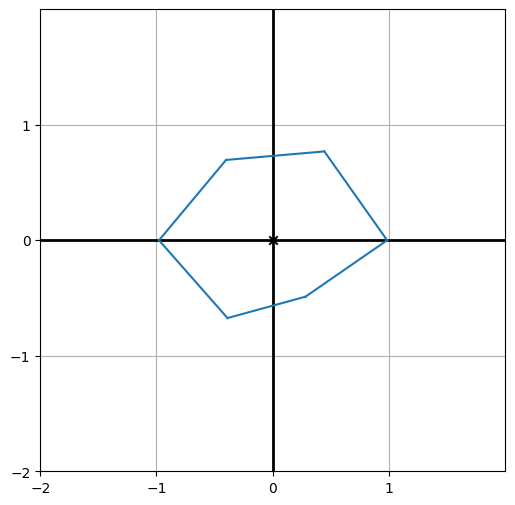

In [12]:
from math import pi
from vec2d.graph import Polygon
from vec2d.math import to_cartesian
from random import randint, uniform

sides = randint(5, 9)
points_polar = [(uniform(0.5, 1), 2 * pi * n / sides) for n in range(sides)]
points_cartesian = [to_cartesian(point_polar) for point_polar in points_polar]

draw(
    Polygon(*points_cartesian)
)



### Rendering the game

For the initial state of the game, we need a ship (which we can iniatilly place at the center of the screen), and a few asteroids that should be randomly spread out over the screen.

That initial state can be coded as:

```python
ship = Ship()

asteroid_count = 10
asteroids = [Asteroid() for _ in range(asteroid_count)]

for asteroid in asteroids:
  ast.x = randint(-9, 9)
  ast.y = randint(-9, 9)
```

This will render something like:

![Asteroid initial state vec2d](pics/asteroids-vec2d.png)

Obviously, rendering the game using our Matplotlib backend is not our goal. Instead, we can use PyGame's built-in 2D graphics engine.

PyGame will allow us to define a screen of agiven size, for example 400x400 pixel screen. Also, PyGame's built-in 2D engine places the `(0, 0)` coordinate in the top-left corner of the window, and the `(400, 400)` on the bottom right.

As a result, we need to do a mapping between the Math-oriented polygon model definition and how we represent them in the PyGame's screen.

Our Math oriented model ranges from `(-10, 10)` to `(10, 10)`, as can be seen in the picture above. We need to build a function `to_pixels(x, y)` that maps the shape coordinates to PyGame's screen coordinates.

The functions that map $ x_{math} \Rightarrow x_{screen} $ and $ y_{math} \Rightarrow y_{screen} $, can be found by assuming those will be linear (and therefore of the form $ ax + b $). With just a couple of points each we can find the corresponding coefficients.

For $ x $:

$
x_{math} = -10 \Rightarrow x_{screen} = 0 \\
x_{math} = 10 \Rightarrow x_{screen} = 400 \\
\begin{cases}
-10 \cdot a + b = 0 \\
10 \cdot a + b = 400 \\
\end{cases}
$

Which give us $ 20 \cdot x + 200 $.

Similarly for y:

$
y_{math} = 10 \Rightarrow y_{screen} = 0 \\
y_{math} = -10 \Rightarrow y_{screen} = 400 \\
\begin{cases}
-10 \cdot a + b = 0 \\
10 \cdot a + b = 400 \\
\end{cases}
$

Which give us $ -20 \cdot y + 200 $.

Thus:

In [ ]:
def to_pixels(x, y):
    x_screen = 20 * x + 200
    y_screen = -20 * y + 200
    return (x_screen, y_screen)

Another optimization we can do is enhance the `PolygonModel` class with a `transformed()` method that will give us the polygon's coordinates after having translated and rotated them in the Math coordinate system:

```python
class PolygonModel:
...
    def transformed(self):
        return translate((self.x, self.y), self.points)
```


By doing so, the initial state on the PyGame system will be achievable by simply doing:

```python
def draw_poly(screen, polygon_model, color=GREEN):
    pixel_points = [to_pixels(x, y) for x, y in polygon_model.transformed()]
    pygame.draw.aalines(screen, color, True, pixel_points)
```

![Asteroids: PyGame](pics/asteroids-pygame.png)

### Shooting the laser

In the 2D world we've modeled, the laser beam should be a line segment starting at the transformed tip of the spaceship and extending in the direction the ship is pointed.

We can make sure it reaches the end of the screen by making it sufficiently long.

As only the Ship can shoot, we can define a `laser_segment` method on the `Ship` class itself.

The method returns the coordinates in the Math model (that is, within the $ -10 \le x \le 10 $, $ -10 \le y \le 10 $ canvas) of a segment that goes from the tip of the ship, to a point that we're sure it sits offscreen.

```python
def laser_segment(self):
    max_width = self.X_MAX - self.X_MIN
    max_height = self.Y_MAX - self.Y_MIN

    max_dist = sqrt(max_width ** 2 + max_height ** 2)
    ship_tip, *_ = self.transformed()
    _, ship_tip_polar_angle = to_polar(ship_tip)
    laser_tip = (max_dist, ship_tip_polar_angle)
    return (ship_tip, to_cartesian(laser_tip))
```

With this in place, we can start looking at what will happen when the laser segment hits an asteroid.

A simplistic, yet valid approach, is to enhance the `PolygonModel` with a `does_intersect(segment)` which returns true if the input segment intersects any segment of the given `PolygonModel`.

Then, in the game loop we check if any of the asteroids intersect with the laser that has been shot, and if it does, we remove the asteroid.

```python
  # Get the state of the keyboard keys
  keys = pygame.key.get_pressed()
  if keys[pygame.K_SPACE]:
      laser_shot = ship.laser_segment()
      draw_segment(screen, laser_shot)

      for asteroid in asteroids:
          if asteroid.does_intersect(laser_shot):
              asteroids.remove(asteroid)
```

We'll implement the `does_intersect` logic in the subsequent sections.

### Exercise

Finish the implementation of the `transformed()` method on the `PolygonModel` that returns the points of the model translated by the object's `x` and `y` attributes and rotated by its `rotation_angle` attribute.

The translation has already been implemented, so only the rotation needs to be added:

```python
def transformed(self):
    rotated_points = rotate(self.rotation_angle, self.points)
    return translate((self.x, self.y), rotated_points)
```

### Exercise

Write a function `to_pixels(x, y)` that takes a pair of x- and y- coordinates in the square where $ -10 < x < 10 $ and $ -10 < y < 10 $ (Math model) and maps to the corresponding PyGame x and y pixel coordinates (Game model), each ranging from 0 to 400.

Can you generalize the solution so that it works for any Math and Game models?

We already elaborated in the solution for the Math model ranging from $ -10 < x < 10 $ and $ -10 < y < 10 $ to `(0, 0)` - `(400, 400)`.

```python
def to_pixels(x, y):
    x_screen = 20 * x + 200
    y_screen = -20 * y + 200
    return (x_screen, y_screen)
```

To make it generic, you just need to use the same approach, but using generic values for:

Math model:

$
x_{math-min}, x_{math-max} \\
y_{math-min}, y_{math-max}
$

Math model:

$
x_{scr-min}, x_{scr-max} \\
y_{scr-min}, y_{scr-max}
$

Then:

$
x_{math} = x_{math-min} \Rightarrow x_{screen} = x_{scr-min} \\
x_{math} = x_{math-max} \Rightarrow x_{screen} = x_{scr-max} \\
\begin{cases}
x_{math-min} \cdot a + b = x_{scr-min} \\
x_{math-max} \cdot a + b = x_{scr-max} \\
\end{cases}
$

Similarly for y:

$
y_{math-min} \cdot a + b = y_{scr-min} \\
y_{math-max} \cdot a + b = y_{scr-max} \\
\begin{cases}
y_{math-min} \cdot a + b = y_{scr-min} \\
y_{math-max} \cdot a + b = y_{scr-max} \\
\end{cases}
$

Solving those pair or systems of linear equations give us the generic solution.

## Finding intersection points of lines